
# **DZONGKHA DIGIT EXTRACTION & PREPROCESSING PIPELINE**

# Setup and Mount Google Drive

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import shutil
from pathlib import Path
import time
from tqdm import tqdm
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive for data storage
print("📁 Mounting Google Drive...")
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive"

# Verify GPU availability for optimal performance
import torch
if torch.cuda.is_available():
    print(f"✅ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"🔥 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️ GPU not available - Enable GPU: Runtime → Change runtime type → GPU")

print("🚀 Dzongkha Digit Extraction Pipeline Initialized")
print("=" * 70)

📁 Mounting Google Drive...
Mounted at /content/drive
✅ GPU Available: Tesla T4
🔥 GPU Memory: 14.7 GB
🚀 Dzongkha Digit Extraction Pipeline Initialized


# Create Directory Structure and Configuration

In [2]:
# Define paths
source_dir = f"{drive_path}/dzongkha_digits"  # Your 17x10 grid images
extracted_dir = f"{drive_path}/extracted_dzongkha_digits"  # Raw extracted digits
processed_dir = f"{drive_path}/processed_dzongkha_digits"  # Final processed digits
samples_dir = f"{drive_path}/dzongkha_samples"  # Sample comparisons

# Create comprehensive directory structure
directories_to_create = [
    extracted_dir,
    processed_dir,
    samples_dir,
    f"{samples_dir}/original_grids",
    f"{samples_dir}/extracted_digits",
    f"{samples_dir}/processed_digits",
    f"{samples_dir}/comparisons"
]

# Create digit subdirectories (0-9) for extracted and processed
for base_dir in [extracted_dir, processed_dir]:
    for digit in range(10):
        directories_to_create.append(f"{base_dir}/{digit}")

# Create all directories
for directory in directories_to_create:
    os.makedirs(directory, exist_ok=True)

print("📁 Directory structure created:")
for directory in directories_to_create[:8]:  # Show first 8
    print(f"   ✅ {directory}")
print(f"   ... and {len(directories_to_create)-8} more directories")

# Configuration for digit extraction
EXTRACTION_CONFIG = {
    'grid_rows': 17,           # Number of rows in each grid
    'grid_cols': 10,           # Number of columns in each grid (digits 0-9)
    'target_size': (28, 28),   # Final size for each digit
    'padding_ratio': 0.1,      # Padding around each extracted digit
    'quality_threshold': 0.3,  # Minimum quality score to keep digit
    'expected_samples': 24     # Expected number of 17x10 grid images
}

print(f"\n⚙️ Extraction Configuration:")
for key, value in EXTRACTION_CONFIG.items():
    print(f"   {key}: {value}")

# Verify source directory exists
if not os.path.exists(source_dir):
    print(f"\n❌ Source directory not found: {source_dir}")
    print("💡 Please ensure your dzongkha_digits folder is uploaded to Google Drive")
else:
    grid_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"\n✅ Found {len(grid_files)} grid images in source directory")
    if len(grid_files) != EXTRACTION_CONFIG['expected_samples']:
        print(f"⚠️ Expected {EXTRACTION_CONFIG['expected_samples']} files, found {len(grid_files)}")

📁 Directory structure created:
   ✅ /content/drive/MyDrive/extracted_dzongkha_digits
   ✅ /content/drive/MyDrive/processed_dzongkha_digits
   ✅ /content/drive/MyDrive/dzongkha_samples
   ✅ /content/drive/MyDrive/dzongkha_samples/original_grids
   ✅ /content/drive/MyDrive/dzongkha_samples/extracted_digits
   ✅ /content/drive/MyDrive/dzongkha_samples/processed_digits
   ✅ /content/drive/MyDrive/dzongkha_samples/comparisons
   ✅ /content/drive/MyDrive/extracted_dzongkha_digits/0
   ... and 19 more directories

⚙️ Extraction Configuration:
   grid_rows: 17
   grid_cols: 10
   target_size: (28, 28)
   padding_ratio: 0.1
   quality_threshold: 0.3
   expected_samples: 24

✅ Found 24 grid images in source directory


# Advanced Grid Analysis and Digit Extraction Functions

In [3]:
def analyze_grid_structure(image_path, config):
    """
    Analyze the structure of a 17x10 digit grid image
    Returns grid dimensions and cell boundaries
    """
    # Read image in color and grayscale
    img_color = cv2.imread(image_path)
    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img_color is None or img_gray is None:
        raise ValueError(f"Could not load image: {image_path}")

    height, width = img_gray.shape

    # Calculate cell dimensions based on expected grid structure
    cell_height = height // config['grid_rows']
    cell_width = width // config['grid_cols']

    # Calculate padding for each cell
    padding_h = int(cell_height * config['padding_ratio'])
    padding_w = int(cell_width * config['padding_ratio'])

    analysis = {
        'image_shape': (height, width),
        'cell_size': (cell_height, cell_width),
        'padding': (padding_h, padding_w),
        'total_cells': config['grid_rows'] * config['grid_cols'],
        'image_color': img_color,
        'image_gray': img_gray
    }

    return analysis

def extract_digit_from_cell(img_gray, row, col, analysis, config):
    """
    Extract a single digit from a specific grid cell with intelligent cropping
    """
    cell_h, cell_w = analysis['cell_size']
    pad_h, pad_w = analysis['padding']

    # Calculate cell boundaries
    start_y = row * cell_h
    end_y = (row + 1) * cell_h
    start_x = col * cell_w
    end_x = (col + 1) * cell_w

    # Extract cell with padding consideration
    cell_img = img_gray[start_y:end_y, start_x:end_x].copy()

    # Apply padding to focus on the digit (remove border noise)
    if pad_h > 0 and pad_w > 0:
        cell_img = cell_img[pad_h:-pad_h, pad_w:-pad_w]

    # Ensure we have a valid image
    if cell_img.size == 0:
        return None, 0.0

    # Quality assessment based on content variance and edge detection
    quality_score = assess_digit_quality(cell_img)

    return cell_img, quality_score

def assess_digit_quality(digit_img):
    """
    Assess the quality of an extracted digit image
    Returns a quality score between 0 and 1
    """
    if digit_img.size == 0:
        return 0.0

    # Factor 1: Variance (higher variance = more content)
    variance = np.var(digit_img) / (255.0 ** 2)  # Normalize to 0-1

    # Factor 2: Edge content (more edges = clearer digit)
    edges = cv2.Canny(digit_img, 50, 150)
    edge_ratio = np.sum(edges > 0) / edges.size

    # Factor 3: Non-uniform distribution (avoid blank or solid images)
    hist = cv2.calcHist([digit_img], [0], None, [256], [0, 256])
    hist_normalized = hist / hist.sum()
    entropy = -np.sum(hist_normalized * np.log2(hist_normalized + 1e-10))
    entropy_normalized = entropy / 8.0  # Max entropy for 8-bit image

    # Factor 4: Contrast (difference between min and max values)
    contrast = (np.max(digit_img) - np.min(digit_img)) / 255.0

    # Combine factors with weights
    quality_score = (
        0.3 * variance +           # Content variance
        0.3 * edge_ratio +         # Edge content
        0.2 * entropy_normalized + # Information content
        0.2 * contrast             # Contrast
    )

    return min(quality_score, 1.0)  # Ensure score doesn't exceed 1.0

def extract_all_digits_from_grid(image_path, config):
    """
    Extract all digits from a single 17x10 grid image
    Returns organized digit data with quality scores
    """
    try:
        # Analyze grid structure
        analysis = analyze_grid_structure(image_path, config)

        # Storage for extracted digits
        extracted_digits = {digit: [] for digit in range(10)}
        extraction_stats = {
            'total_extracted': 0,
            'high_quality': 0,
            'medium_quality': 0,
            'low_quality': 0,
            'failed_extractions': 0
        }

        # Extract digits from each cell
        for row in range(config['grid_rows']):
            for col in range(config['grid_cols']):
                # Extract digit from current cell
                digit_img, quality = extract_digit_from_cell(
                    analysis['image_gray'], row, col, analysis, config
                )

                if digit_img is not None:
                    # Store digit with metadata
                    digit_data = {
                        'image': digit_img,
                        'quality': quality,
                        'position': (row, col),
                        'source_file': os.path.basename(image_path)
                    }

                    # Assign to appropriate digit class (column determines digit)
                    extracted_digits[col].append(digit_data)
                    extraction_stats['total_extracted'] += 1

                    # Categorize by quality
                    if quality >= 0.7:
                        extraction_stats['high_quality'] += 1
                    elif quality >= 0.4:
                        extraction_stats['medium_quality'] += 1
                    else:
                        extraction_stats['low_quality'] += 1
                else:
                    extraction_stats['failed_extractions'] += 1

        return extracted_digits, extraction_stats, analysis

    except Exception as e:
        print(f"❌ Error extracting from {image_path}: {e}")
        return None, None, None

print("🔧 Advanced extraction functions defined:")
print("   ✅ analyze_grid_structure() - Intelligent grid analysis")
print("   ✅ extract_digit_from_cell() - Precise digit extraction")
print("   ✅ assess_digit_quality() - Multi-factor quality assessment")
print("   ✅ extract_all_digits_from_grid() - Complete grid processing")

🔧 Advanced extraction functions defined:
   ✅ analyze_grid_structure() - Intelligent grid analysis
   ✅ extract_digit_from_cell() - Precise digit extraction
   ✅ assess_digit_quality() - Multi-factor quality assessment
   ✅ extract_all_digits_from_grid() - Complete grid processing


# Execute Digit Extraction from All Grid Images

In [4]:
def extract_digits_from_all_grids(source_dir, extracted_dir, config):
    """
    Process all grid images and extract digits with comprehensive logging
    """
    # Get all grid image files
    grid_files = [f for f in os.listdir(source_dir)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not grid_files:
        raise ValueError(f"No image files found in {source_dir}")

    print(f"🔄 Processing {len(grid_files)} grid images...")
    print(f"📊 Expected total digits: {len(grid_files) * config['grid_rows'] * config['grid_cols']}")

    # Global statistics
    global_stats = {
        'total_grids_processed': 0,
        'total_digits_extracted': 0,
        'digits_per_class': {digit: 0 for digit in range(10)},
        'quality_distribution': {'high': 0, 'medium': 0, 'low': 0},
        'failed_extractions': 0,
        'processing_time': 0
    }

    # Sample storage for visualization
    sample_extractions = {digit: [] for digit in range(10)}

    start_time = time.time()

    # Process each grid image
    for i, grid_file in enumerate(tqdm(grid_files, desc="Extracting digits")):
        grid_path = os.path.join(source_dir, grid_file)

        print(f"\n📋 Processing grid {i+1}/{len(grid_files)}: {grid_file}")

        # Extract all digits from current grid
        extracted_digits, extraction_stats, analysis = extract_all_digits_from_grid(
            grid_path, config
        )

        if extracted_digits is None:
            print(f"❌ Failed to process {grid_file}")
            continue

        # Save extracted digits to appropriate folders
        for digit_class, digit_list in extracted_digits.items():
            for j, digit_data in enumerate(digit_list):
                # Generate unique filename
                filename = f"grid{i+1:02d}_row{digit_data['position'][0]:02d}_col{digit_data['position'][1]:02d}_q{digit_data['quality']:.2f}.png"
                save_path = os.path.join(extracted_dir, str(digit_class), filename)

                # Save digit image
                cv2.imwrite(save_path, digit_data['image'])

                # Store sample for visualization (first few from each class)
                if len(sample_extractions[digit_class]) < 3:
                    sample_extractions[digit_class].append({
                        'image': digit_data['image'],
                        'quality': digit_data['quality'],
                        'filename': filename,
                        'source_grid': grid_file
                    })

        # Update global statistics
        global_stats['total_grids_processed'] += 1
        global_stats['total_digits_extracted'] += extraction_stats['total_extracted']
        global_stats['quality_distribution']['high'] += extraction_stats['high_quality']
        global_stats['quality_distribution']['medium'] += extraction_stats['medium_quality']
        global_stats['quality_distribution']['low'] += extraction_stats['low_quality']
        global_stats['failed_extractions'] += extraction_stats['failed_extractions']

        # Update per-class counts
        for digit_class, digit_list in extracted_digits.items():
            global_stats['digits_per_class'][digit_class] += len(digit_list)

        # Print progress for current grid
        print(f"   ✅ Extracted {extraction_stats['total_extracted']} digits")
        print(f"   📊 Quality: {extraction_stats['high_quality']} high, "
              f"{extraction_stats['medium_quality']} medium, "
              f"{extraction_stats['low_quality']} low")

    global_stats['processing_time'] = time.time() - start_time

    return global_stats, sample_extractions

# Execute digit extraction
print("🚀 Starting digit extraction from all grid images...")
print("=" * 70)

try:
    extraction_results, sample_digits = extract_digits_from_all_grids(
        source_dir, extracted_dir, EXTRACTION_CONFIG
    )

    # Display comprehensive results
    print(f"\n🎉 DIGIT EXTRACTION COMPLETED!")
    print("=" * 50)
    print(f"⏱️  Processing time: {extraction_results['processing_time']:.1f} seconds")
    print(f"📊 Grids processed: {extraction_results['total_grids_processed']}")
    print(f"🔢 Total digits extracted: {extraction_results['total_digits_extracted']}")
    print(f"❌ Failed extractions: {extraction_results['failed_extractions']}")

    print(f"\n📈 Quality Distribution:")
    print(f"   🟢 High quality (≥0.7): {extraction_results['quality_distribution']['high']}")
    print(f"   🟡 Medium quality (0.4-0.7): {extraction_results['quality_distribution']['medium']}")
    print(f"   🔴 Low quality (<0.4): {extraction_results['quality_distribution']['low']}")

    print(f"\n🔢 Digits per class:")
    for digit, count in extraction_results['digits_per_class'].items():
        print(f"   Digit {digit}: {count} samples")

    # Check for class balance
    counts = list(extraction_results['digits_per_class'].values())
    if len(set(counts)) == 1:
        print(f"✅ Perfect class balance: {counts[0]} samples per digit")
    else:
        print(f"⚠️ Class imbalance detected - Min: {min(counts)}, Max: {max(counts)}")

    # Save extraction statistics
    stats_file = f"{drive_path}/dzongkha_extraction_stats.json"
    with open(stats_file, 'w') as f:
        json.dump({
            'extraction_results': extraction_results,
            'extraction_config': EXTRACTION_CONFIG,
            'timestamp': datetime.now().isoformat()
        }, f, indent=2)

    print(f"\n💾 Extraction statistics saved to: {stats_file}")

except Exception as e:
    print(f"❌ Extraction failed: {e}")
    extraction_results = None
    sample_digits = None

🚀 Starting digit extraction from all grid images...
🔄 Processing 24 grid images...
📊 Expected total digits: 4080


Extracting digits:   0%|          | 0/24 [00:00<?, ?it/s]


📋 Processing grid 1/24: image5.jpg


Extracting digits:   4%|▍         | 1/24 [00:01<00:45,  1.99s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 2/24: image20.jpg


Extracting digits:   8%|▊         | 2/24 [00:04<00:44,  2.00s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 3/24: image4.jpg


Extracting digits:  12%|█▎        | 3/24 [00:05<00:41,  1.97s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 4/24: image7.jpg


Extracting digits:  17%|█▋        | 4/24 [00:07<00:35,  1.76s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 5/24: image6.jpg


Extracting digits:  21%|██        | 5/24 [00:09<00:33,  1.76s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 6/24: image8.jpg


Extracting digits:  25%|██▌       | 6/24 [00:11<00:34,  1.89s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 7/24: image9.jpg


Extracting digits:  29%|██▉       | 7/24 [00:12<00:29,  1.73s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 8/24: image10.jpg


Extracting digits:  33%|███▎      | 8/24 [00:14<00:26,  1.63s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 9/24: image11.jpg


Extracting digits:  38%|███▊      | 9/24 [00:15<00:23,  1.59s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 10/24: image12.jpg


Extracting digits:  42%|████▏     | 10/24 [00:18<00:26,  1.90s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 11/24: image14.jpg


Extracting digits:  46%|████▌     | 11/24 [00:20<00:24,  1.90s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 12/24: image15.jpg


Extracting digits:  50%|█████     | 12/24 [00:21<00:21,  1.76s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 13/24: image13.jpg


Extracting digits:  54%|█████▍    | 13/24 [00:23<00:20,  1.86s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 14/24: image24.jpg


Extracting digits:  58%|█████▊    | 14/24 [00:25<00:17,  1.80s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 15/24: image16.jpg


Extracting digits:  62%|██████▎   | 15/24 [00:27<00:16,  1.78s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 16/24: image19.jpg


Extracting digits:  67%|██████▋   | 16/24 [00:29<00:16,  2.08s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 17/24: image23.jpg


Extracting digits:  71%|███████   | 17/24 [00:31<00:13,  1.92s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 18/24: image3.jpg


Extracting digits:  75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 19/24: image18.jpg


Extracting digits:  79%|███████▉  | 19/24 [00:34<00:09,  1.85s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 20/24: image2.jpg


Extracting digits:  83%|████████▎ | 20/24 [00:36<00:06,  1.71s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 21/24: image22.jpg


Extracting digits:  88%|████████▊ | 21/24 [00:37<00:04,  1.63s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 22/24: image17.jpg


Extracting digits:  92%|█████████▏| 22/24 [00:39<00:03,  1.58s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 23/24: image1.jpg


Extracting digits:  96%|█████████▌| 23/24 [00:40<00:01,  1.60s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

📋 Processing grid 24/24: image21.jpg


Extracting digits: 100%|██████████| 24/24 [00:43<00:00,  1.80s/it]

   ✅ Extracted 170 digits
   📊 Quality: 0 high, 0 medium, 170 low

🎉 DIGIT EXTRACTION COMPLETED!
⏱️  Processing time: 43.1 seconds
📊 Grids processed: 24
🔢 Total digits extracted: 4080
❌ Failed extractions: 0

📈 Quality Distribution:
   🟢 High quality (≥0.7): 0
   🟡 Medium quality (0.4-0.7): 0
   🔴 Low quality (<0.4): 4080

🔢 Digits per class:
   Digit 0: 408 samples
   Digit 1: 408 samples
   Digit 2: 408 samples
   Digit 3: 408 samples
   Digit 4: 408 samples
   Digit 5: 408 samples
   Digit 6: 408 samples
   Digit 7: 408 samples
   Digit 8: 408 samples
   Digit 9: 408 samples
✅ Perfect class balance: 408 samples per digit

💾 Extraction statistics saved to: /content/drive/MyDrive/dzongkha_extraction_stats.json



# Advanced Preprocessing Pipeline for Extracted Digits

In [5]:
def preprocess_digit_image(img, target_size=(28, 28)):
    """
    Advanced preprocessing pipeline for individual digit images
    Optimized for Dzongkha digit recognition
    """
    if img is None or img.size == 0:
        return np.zeros(target_size, dtype=np.uint8)

    # Store original for comparison
    original = img.copy()

    # STAGE 1: Noise reduction and smoothing
    # Apply bilateral filter to reduce noise while preserving edges
    img = cv2.bilateralFilter(img, 9, 75, 75)

    # STAGE 2: Contrast enhancement
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    img = clahe.apply(img)

    # STAGE 3: Adaptive thresholding for better digit separation
    # Use Otsu's method combined with Gaussian adaptive threshold
    _, otsu_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    adaptive_thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV, 11, 2)

    # Combine both thresholding methods for better results
    img = cv2.bitwise_or(otsu_thresh, adaptive_thresh)

    # STAGE 4: Morphological operations for digit cleanup
    # Remove small noise and fill small holes
    kernel_small = np.ones((2, 2), np.uint8)
    kernel_medium = np.ones((3, 3), np.uint8)

    # Remove small noise
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_small)
    # Fill small holes in digits
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_medium)

    # STAGE 5: Digit isolation and centering
    # Find contours to identify the main digit
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find the largest contour (should be the main digit)
        largest_contour = max(contours, key=cv2.contourArea)

        # Get bounding rectangle of the digit
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Extract digit region with some padding
        padding = 2
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(img.shape[1] - x, w + 2 * padding)
        h = min(img.shape[0] - y, h + 2 * padding)

        digit_region = img[y:y+h, x:x+w]

        # Resize digit region to fit in target size while maintaining aspect ratio
        aspect_ratio = w / h
        if aspect_ratio > 1:  # Wider than tall
            new_w = target_size[1] - 4  # Leave some border
            new_h = int(new_w / aspect_ratio)
        else:  # Taller than wide
            new_h = target_size[0] - 4  # Leave some border
            new_w = int(new_h * aspect_ratio)

        # Ensure minimum size
        new_w = max(new_w, 8)
        new_h = max(new_h, 8)

        # Resize the digit
        if digit_region.size > 0:
            digit_resized = cv2.resize(digit_region, (new_w, new_h), interpolation=cv2.INTER_AREA)

            # Center the resized digit in target canvas
            centered_img = np.zeros(target_size, dtype=np.uint8)
            start_y = (target_size[0] - new_h) // 2
            start_x = (target_size[1] - new_w) // 2

            centered_img[start_y:start_y+new_h, start_x:start_x+new_w] = digit_resized
            img = centered_img
        else:
            # Fallback: just resize original
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    else:
        # No contours found, just resize
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    # STAGE 6: Final enhancement
    # Slight dilation to make digits more prominent
    kernel_final = np.ones((2, 2), np.uint8)
    img = cv2.dilate(img, kernel_final, iterations=1)

    # Ensure binary image (0 or 255)
    _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    return img

def process_all_extracted_digits(extracted_dir, processed_dir, config):
    """
    Apply preprocessing to all extracted digits with quality tracking
    """
    print("🔄 Starting preprocessing of all extracted digits...")

    processing_stats = {
        'total_processed': 0,
        'successful_processing': 0,
        'failed_processing': 0,
        'digits_per_class': {digit: 0 for digit in range(10)},
        'processing_time': 0
    }

    # Sample storage for before/after comparison
    preprocessing_samples = {digit: [] for digit in range(10)}

    start_time = time.time()

    # Process each digit class
    for digit_class in range(10):
        extracted_class_dir = os.path.join(extracted_dir, str(digit_class))
        processed_class_dir = os.path.join(processed_dir, str(digit_class))

        if not os.path.exists(extracted_class_dir):
            print(f"⚠️ No extracted digits found for class {digit_class}")
            continue

        # Get all extracted digit files for this class
        digit_files = [f for f in os.listdir(extracted_class_dir)
                      if f.lower().endswith('.png')]

        print(f"📋 Processing {len(digit_files)} digits for class {digit_class}")

        # Process each digit file
        for digit_file in tqdm(digit_files, desc=f"Digit {digit_class}"):
            try:
                # Load extracted digit
                extracted_path = os.path.join(extracted_class_dir, digit_file)
                original_img = cv2.imread(extracted_path, cv2.IMREAD_GRAYSCALE)

                if original_img is None:
                    processing_stats['failed_processing'] += 1
                    continue

                # Apply preprocessing
                processed_img = preprocess_digit_image(original_img, config['target_size'])

                # Save processed digit
                processed_path = os.path.join(processed_class_dir, digit_file)
                cv2.imwrite(processed_path, processed_img)

                # Store sample for visualization (first few from each class)
                if len(preprocessing_samples[digit_class]) < 3:
                    preprocessing_samples[digit_class].append({
                        'original': original_img,
                        'processed': processed_img,
                        'filename': digit_file
                    })

                processing_stats['successful_processing'] += 1
                processing_stats['digits_per_class'][digit_class] += 1

            except Exception as e:
                print(f"❌ Error processing {digit_file}: {e}")
                processing_stats['failed_processing'] += 1

            processing_stats['total_processed'] += 1

    processing_stats['processing_time'] = time.time() - start_time

    return processing_stats, preprocessing_samples

# Execute preprocessing if extraction was successful
if extraction_results is not None:
    print("🚀 Starting advanced preprocessing pipeline...")
    print("=" * 70)

    preprocessing_results, preprocessing_samples = process_all_extracted_digits(
        extracted_dir, processed_dir, EXTRACTION_CONFIG
    )

    # Display preprocessing results
    print(f"\n🎉 PREPROCESSING COMPLETED!")
    print("=" * 50)
    print(f"⏱️  Processing time: {preprocessing_results['processing_time']:.1f} seconds")
    print(f"📊 Total processed: {preprocessing_results['total_processed']}")
    print(f"✅ Successful: {preprocessing_results['successful_processing']}")
    print(f"❌ Failed: {preprocessing_results['failed_processing']}")

    print(f"\n🔢 Processed digits per class:")
    for digit, count in preprocessing_results['digits_per_class'].items():
        print(f"   Digit {digit}: {count} samples")

    # Save preprocessing statistics
    preprocessing_stats_file = f"{drive_path}/dzongkha_preprocessing_stats.json"
    with open(preprocessing_stats_file, 'w') as f:
        json.dump({
            'preprocessing_results': preprocessing_results,
            'extraction_results': extraction_results,
            'config': EXTRACTION_CONFIG,
            'timestamp': datetime.now().isoformat()
        }, f, indent=2)

    print(f"\n💾 Preprocessing statistics saved to: {preprocessing_stats_file}")

else:
    print("❌ Skipping preprocessing due to extraction failure")
    preprocessing_results = None
    preprocessing_samples = None

🚀 Starting advanced preprocessing pipeline...
🔄 Starting preprocessing of all extracted digits...
📋 Processing 408 digits for class 0


Digit 0: 100%|██████████| 408/408 [00:06<00:00, 65.71it/s]


📋 Processing 408 digits for class 1


Digit 1: 100%|██████████| 408/408 [00:06<00:00, 61.24it/s]


📋 Processing 408 digits for class 2


Digit 2: 100%|██████████| 408/408 [00:06<00:00, 59.91it/s]


📋 Processing 408 digits for class 3


Digit 3: 100%|██████████| 408/408 [00:07<00:00, 54.47it/s]


📋 Processing 408 digits for class 4


Digit 4: 100%|██████████| 408/408 [00:07<00:00, 55.22it/s]


📋 Processing 408 digits for class 5


Digit 5: 100%|██████████| 408/408 [00:06<00:00, 58.46it/s]


📋 Processing 408 digits for class 6


Digit 6: 100%|██████████| 408/408 [00:06<00:00, 63.78it/s]


📋 Processing 408 digits for class 7


Digit 7: 100%|██████████| 408/408 [00:07<00:00, 55.18it/s]


📋 Processing 408 digits for class 8


Digit 8: 100%|██████████| 408/408 [00:07<00:00, 57.76it/s]


📋 Processing 408 digits for class 9


Digit 9: 100%|██████████| 408/408 [00:07<00:00, 55.01it/s]


🎉 PREPROCESSING COMPLETED!
⏱️  Processing time: 70.0 seconds
📊 Total processed: 4080
✅ Successful: 4080
❌ Failed: 0

🔢 Processed digits per class:
   Digit 0: 408 samples
   Digit 1: 408 samples
   Digit 2: 408 samples
   Digit 3: 408 samples
   Digit 4: 408 samples
   Digit 5: 408 samples
   Digit 6: 408 samples
   Digit 7: 408 samples
   Digit 8: 408 samples
   Digit 9: 408 samples

💾 Preprocessing statistics saved to: /content/drive/MyDrive/dzongkha_preprocessing_stats.json


# Comprehensive Visualization and Quality Assessment

📊 Creating comprehensive visualizations...


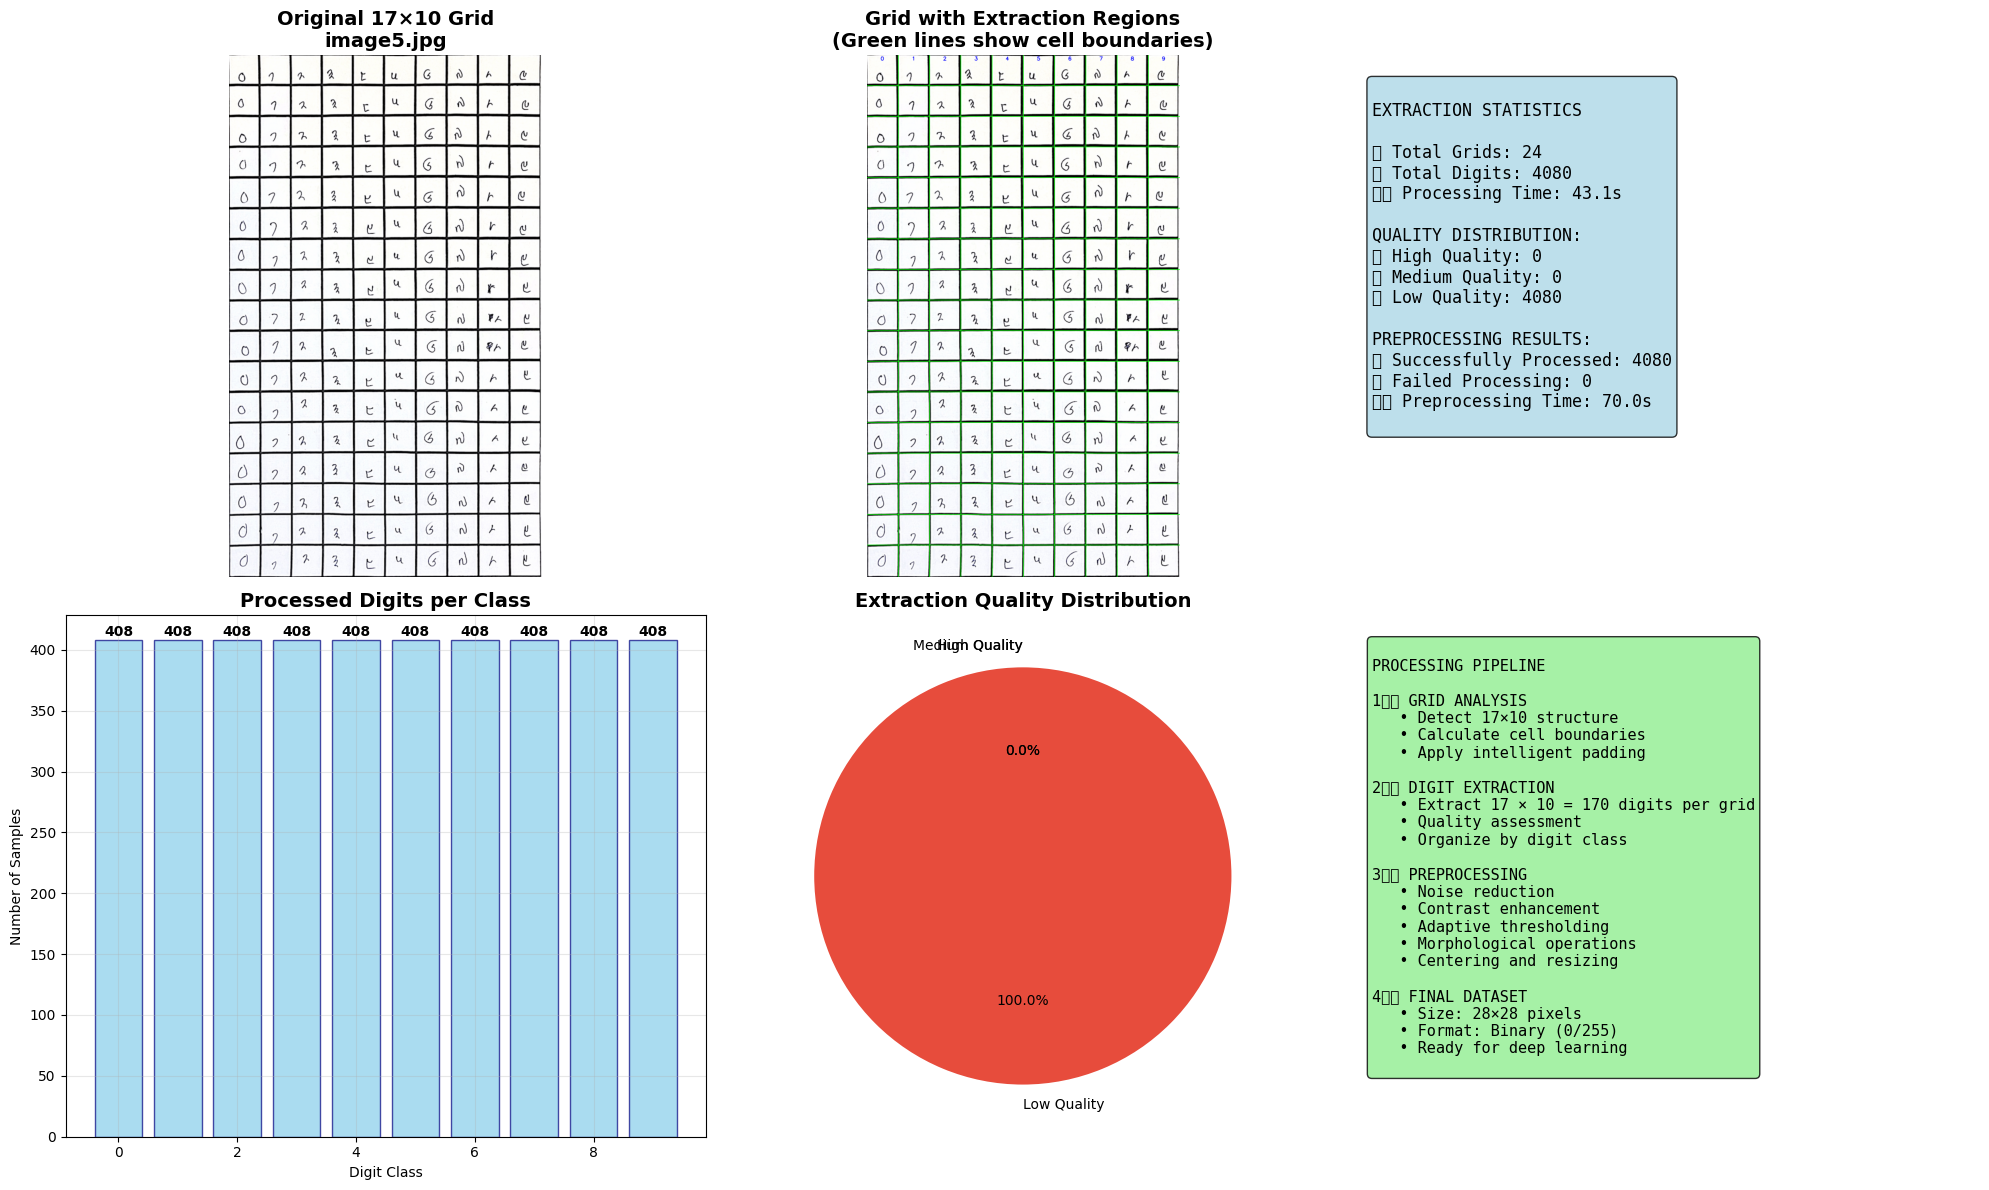


📋 Creating detailed before/after comparisons...


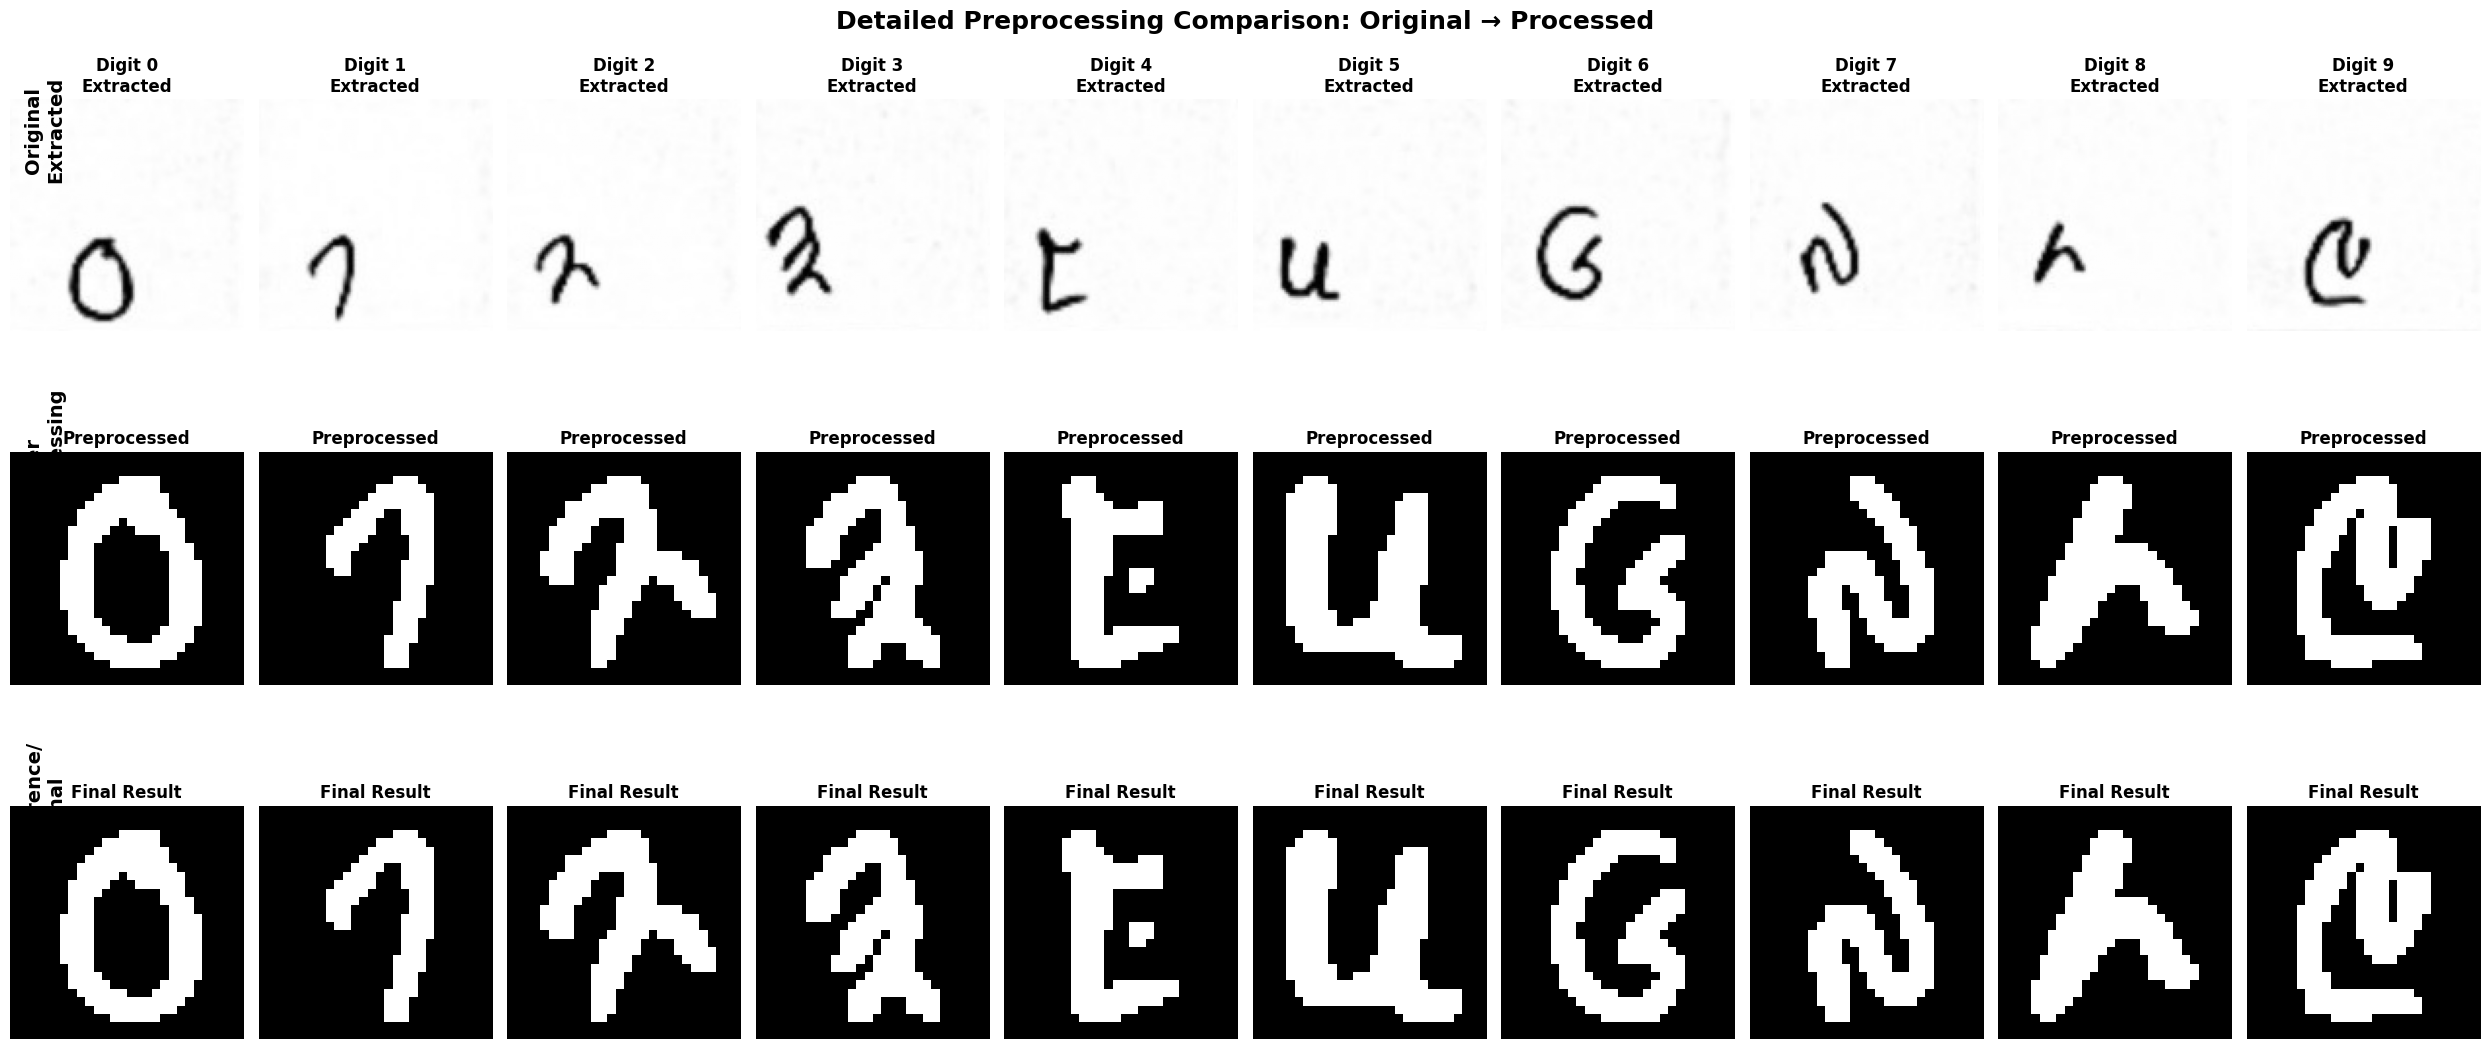


🔍 Creating quality analysis visualization...


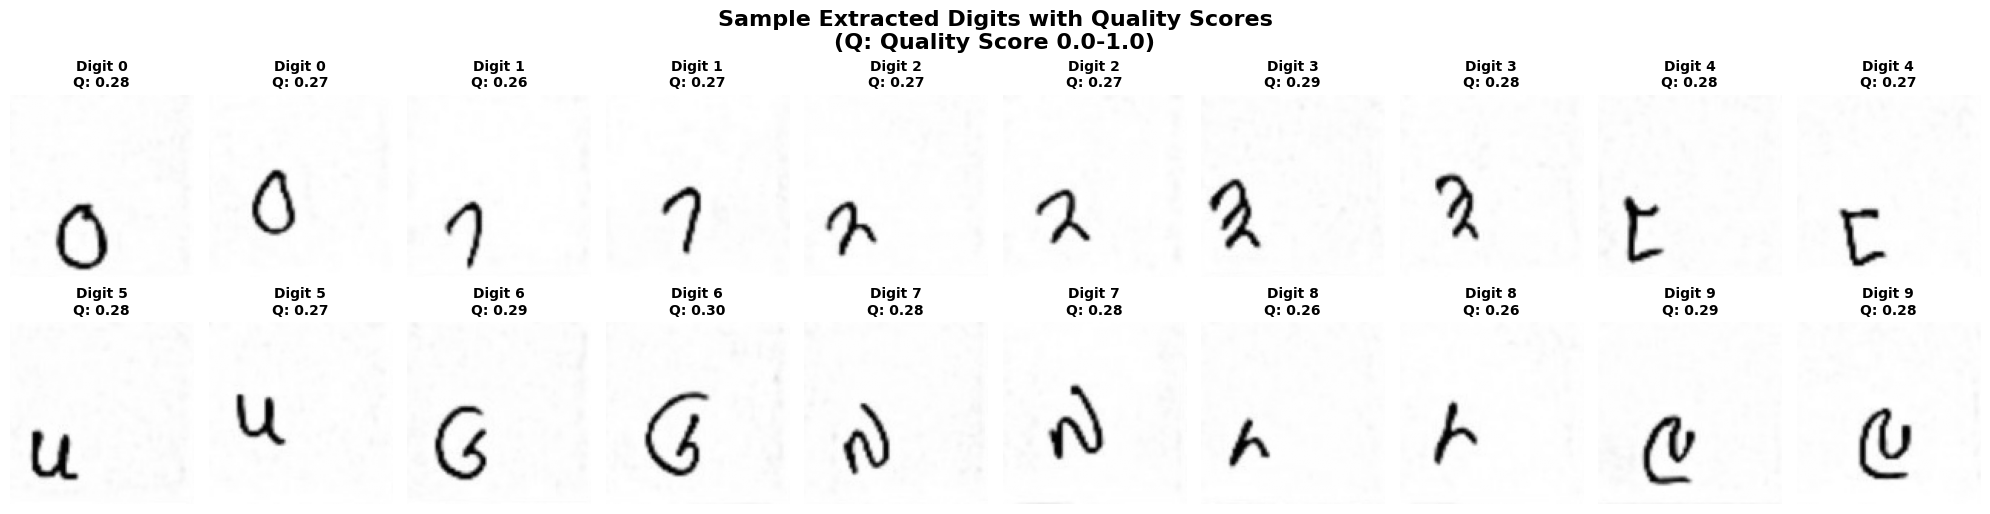


🎉 ALL VISUALIZATIONS COMPLETED!
📁 Visualizations saved to: /content/drive/MyDrive/dzongkha_samples


In [6]:
def create_comprehensive_visualization():
    """
    Create detailed visualizations showing the complete pipeline
    """
    if extraction_results is None or preprocessing_results is None:
        print("❌ Cannot create visualizations - pipeline incomplete")
        return

    # VISUALIZATION 1: Sample original grid with extraction overlay
    print("📊 Creating comprehensive visualizations...")

    # Get first grid image for demonstration
    grid_files = [f for f in os.listdir(source_dir)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if grid_files:
        sample_grid_path = os.path.join(source_dir, grid_files[0])
        sample_grid = cv2.imread(sample_grid_path)
        sample_grid_gray = cv2.imread(sample_grid_path, cv2.IMREAD_GRAYSCALE)

        # Create grid overlay showing extraction regions
        plt.figure(figsize=(20, 12))

        # Original grid
        plt.subplot(2, 3, 1)
        plt.imshow(cv2.cvtColor(sample_grid, cv2.COLOR_BGR2RGB))
        plt.title(f"Original 17×10 Grid\n{grid_files[0]}", fontsize=14, fontweight='bold')
        plt.axis('off')

        # Grid with extraction overlay
        plt.subplot(2, 3, 2)
        overlay = sample_grid.copy()

        # Draw grid lines to show extraction regions
        height, width = sample_grid_gray.shape
        cell_h = height // EXTRACTION_CONFIG['grid_rows']
        cell_w = width // EXTRACTION_CONFIG['grid_cols']

        # Draw vertical lines (column separators)
        for col in range(1, EXTRACTION_CONFIG['grid_cols']):
            x = col * cell_w
            cv2.line(overlay, (x, 0), (x, height), (0, 255, 0), 2)

        # Draw horizontal lines (row separators)
        for row in range(1, EXTRACTION_CONFIG['grid_rows']):
            y = row * cell_h
            cv2.line(overlay, (0, y), (width, y), (0, 255, 0), 2)

        # Add digit labels at top
        for col in range(EXTRACTION_CONFIG['grid_cols']):
            x = col * cell_w + cell_w // 2
            cv2.putText(overlay, str(col), (x-10, 25), cv2.FONT_HERSHEY_SIMPLEX,
                       0.8, (255, 0, 0), 2)

        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title("Grid with Extraction Regions\n(Green lines show cell boundaries)",
                 fontsize=14, fontweight='bold')
        plt.axis('off')

        # Extraction statistics
        plt.subplot(2, 3, 3)
        plt.axis('off')
        stats_text = f"""
EXTRACTION STATISTICS

📊 Total Grids: {extraction_results['total_grids_processed']}
🔢 Total Digits: {extraction_results['total_digits_extracted']}
⏱️ Processing Time: {extraction_results['processing_time']:.1f}s

QUALITY DISTRIBUTION:
🟢 High Quality: {extraction_results['quality_distribution']['high']}
🟡 Medium Quality: {extraction_results['quality_distribution']['medium']}
🔴 Low Quality: {extraction_results['quality_distribution']['low']}

PREPROCESSING RESULTS:
✅ Successfully Processed: {preprocessing_results['successful_processing']}
❌ Failed Processing: {preprocessing_results['failed_processing']}
⏱️ Preprocessing Time: {preprocessing_results['processing_time']:.1f}s
"""
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
                fontsize=12, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

        # Class distribution chart
        plt.subplot(2, 3, 4)
        digits = list(range(10))
        counts = [preprocessing_results['digits_per_class'][d] for d in digits]

        bars = plt.bar(digits, counts, color='skyblue', edgecolor='navy', alpha=0.7)
        plt.title('Processed Digits per Class', fontsize=14, fontweight='bold')
        plt.xlabel('Digit Class')
        plt.ylabel('Number of Samples')
        plt.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                    str(count), ha='center', va='bottom', fontweight='bold')

        # Quality distribution pie chart
        plt.subplot(2, 3, 5)
        quality_labels = ['High Quality', 'Medium Quality', 'Low Quality']
        quality_counts = [
            extraction_results['quality_distribution']['high'],
            extraction_results['quality_distribution']['medium'],
            extraction_results['quality_distribution']['low']
        ]
        colors = ['#2ecc71', '#f39c12', '#e74c3c']

        plt.pie(quality_counts, labels=quality_labels, colors=colors, autopct='%1.1f%%',
               startangle=90)
        plt.title('Extraction Quality Distribution', fontsize=14, fontweight='bold')

        # Processing pipeline overview
        plt.subplot(2, 3, 6)
        plt.axis('off')
        pipeline_text = f"""
PROCESSING PIPELINE

1️⃣ GRID ANALYSIS
   • Detect 17×10 structure
   • Calculate cell boundaries
   • Apply intelligent padding

2️⃣ DIGIT EXTRACTION
   • Extract {EXTRACTION_CONFIG['grid_rows']} × {EXTRACTION_CONFIG['grid_cols']} = {EXTRACTION_CONFIG['grid_rows'] * EXTRACTION_CONFIG['grid_cols']} digits per grid
   • Quality assessment
   • Organize by digit class

3️⃣ PREPROCESSING
   • Noise reduction
   • Contrast enhancement
   • Adaptive thresholding
   • Morphological operations
   • Centering and resizing

4️⃣ FINAL DATASET
   • Size: {EXTRACTION_CONFIG['target_size'][0]}×{EXTRACTION_CONFIG['target_size'][1]} pixels
   • Format: Binary (0/255)
   • Ready for deep learning
"""
        plt.text(0.05, 0.95, pipeline_text, transform=plt.gca().transAxes,
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

        plt.tight_layout()
        plt.savefig(f"{samples_dir}/comprehensive_pipeline_overview.png",
                   dpi=300, bbox_inches='tight')
        plt.show()

def create_detailed_comparison_visualization():
    """
    Create detailed before/after comparisons for each digit class
    """
    if preprocessing_samples is None:
        print("❌ No preprocessing samples available")
        return

    # VISUALIZATION 2: Detailed before/after comparison
    print("\n📋 Creating detailed before/after comparisons...")

    fig, axes = plt.subplots(3, 10, figsize=(25, 12))

    for digit in range(10):
        if digit in preprocessing_samples and preprocessing_samples[digit]:
            # Get first sample for this digit
            sample = preprocessing_samples[digit][0]

            # Original extracted digit
            axes[0, digit].imshow(sample['original'], cmap='gray')
            axes[0, digit].set_title(f'Digit {digit}\nExtracted', fontsize=12, fontweight='bold')
            axes[0, digit].axis('off')

            # Processed digit
            axes[1, digit].imshow(sample['processed'], cmap='gray')
            axes[1, digit].set_title('Preprocessed', fontsize=12, fontweight='bold')
            axes[1, digit].axis('off')

            # Difference visualization
            if sample['original'].shape == sample['processed'].shape:
                diff = cv2.absdiff(sample['original'], sample['processed'])
                axes[2, digit].imshow(diff, cmap='hot')
                axes[2, digit].set_title('Difference', fontsize=12, fontweight='bold')
            else:
                # If shapes don't match, show processed again
                axes[2, digit].imshow(sample['processed'], cmap='gray')
                axes[2, digit].set_title('Final Result', fontsize=12, fontweight='bold')
            axes[2, digit].axis('off')
        else:
            # No sample available for this digit
            for row in range(3):
                axes[row, digit].text(0.5, 0.5, 'No Sample', ha='center', va='center',
                                    transform=axes[row, digit].transAxes, fontsize=12)
                axes[row, digit].axis('off')

    # Add row labels
    row_labels = ['Original\nExtracted', 'After\nPreprocessing', 'Difference/\nFinal']
    for i, label in enumerate(row_labels):
        fig.text(0.02, 0.85 - i*0.28, label, fontsize=14, fontweight='bold',
                rotation=90, va='center', ha='center')

    plt.suptitle('Detailed Preprocessing Comparison: Original → Processed',
                fontsize=18, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.savefig(f"{samples_dir}/detailed_preprocessing_comparison.png",
               dpi=300, bbox_inches='tight')
    plt.show()

def create_quality_analysis_visualization():
    """
    Create visualization showing quality distribution and sample quality scores
    """
    if sample_digits is None:
        print("❌ No sample digits available for quality analysis")
        return

    print("\n🔍 Creating quality analysis visualization...")

    plt.figure(figsize=(20, 10))

    # Show samples with different quality scores
    sample_count = 0
    for digit in range(10):
        if digit in sample_digits and sample_digits[digit]:
            for i, sample in enumerate(sample_digits[digit][:2]):  # Show 2 samples per digit
                plt.subplot(4, 10, sample_count + 1)
                plt.imshow(sample['image'], cmap='gray')
                plt.title(f"Digit {digit}\nQ: {sample['quality']:.2f}",
                         fontsize=10, fontweight='bold')
                plt.axis('off')
                sample_count += 1

                if sample_count >= 20:  # Limit to 20 samples
                    break
        if sample_count >= 20:
            break

    plt.suptitle('Sample Extracted Digits with Quality Scores\n(Q: Quality Score 0.0-1.0)',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{samples_dir}/quality_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

# Create all visualizations
create_comprehensive_visualization()
create_detailed_comparison_visualization()
create_quality_analysis_visualization()

print("\n🎉 ALL VISUALIZATIONS COMPLETED!")
print(f"📁 Visualizations saved to: {samples_dir}")
print("=" * 70)

# Final Dataset Validation and Summary


📋 Creating final summary report...
🔍 Validating final dataset for training readiness...


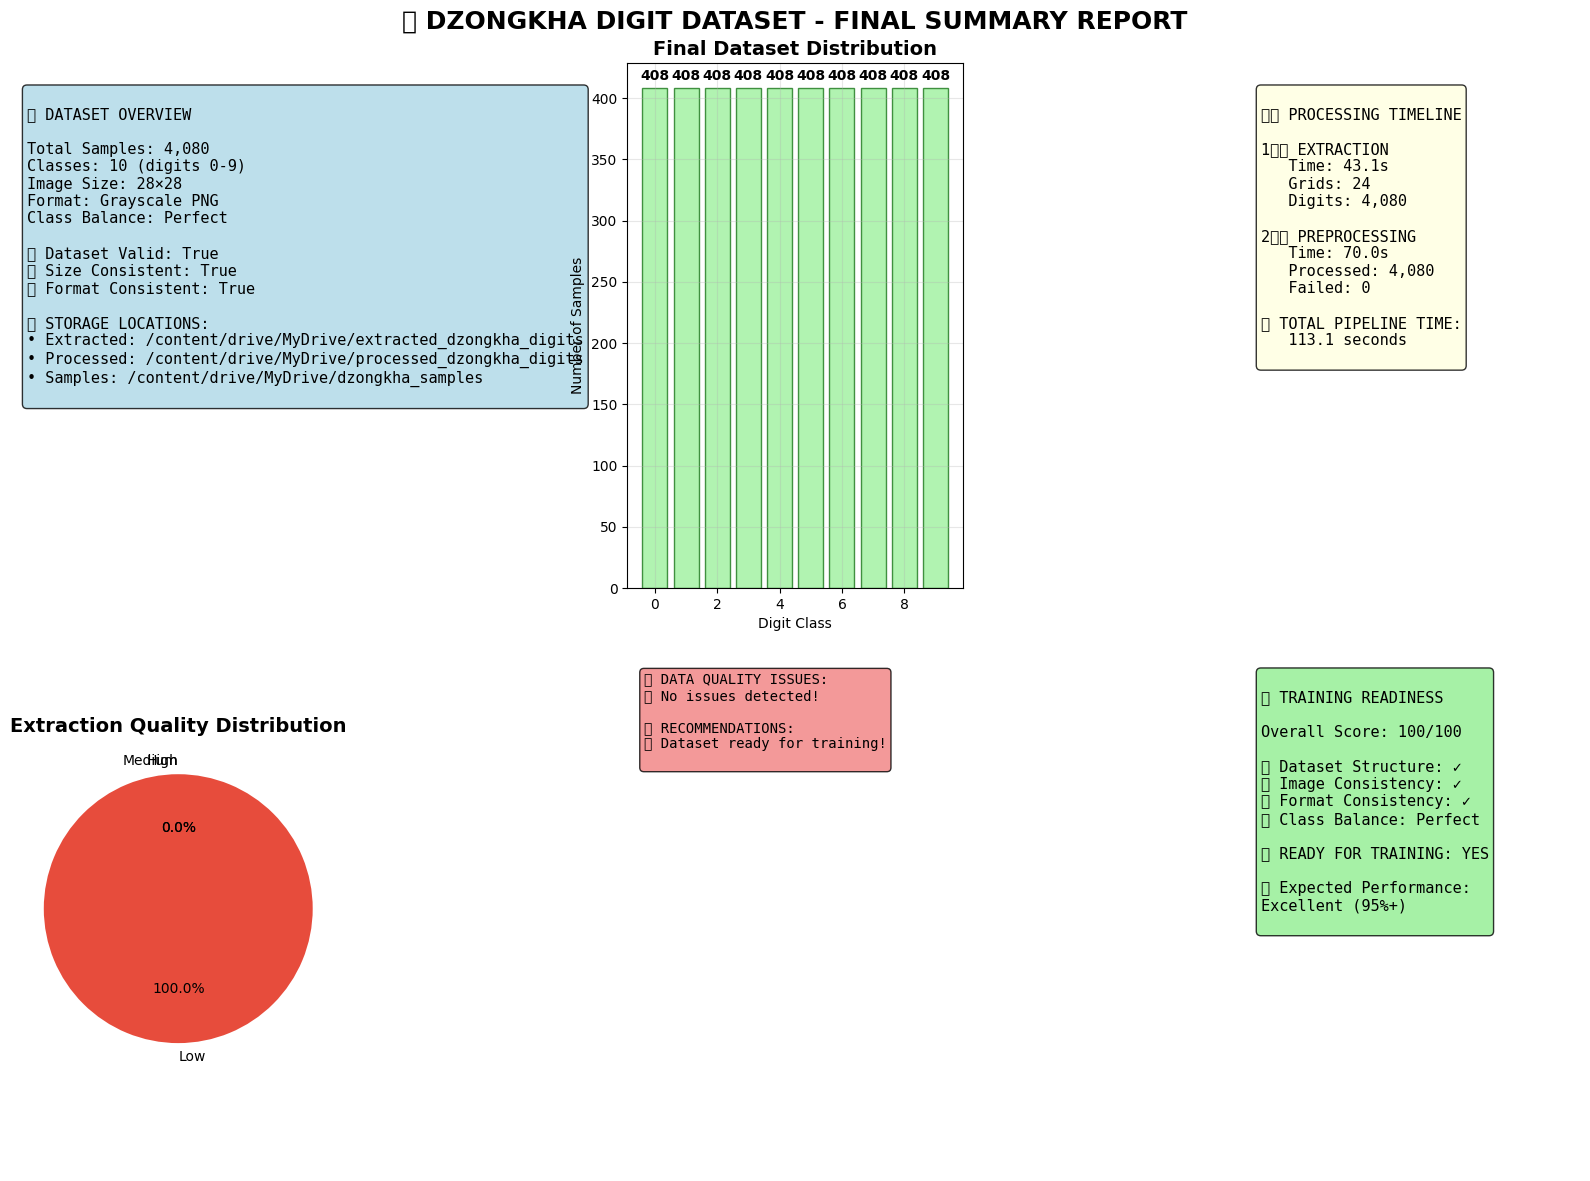


🎉 DZONGKHA DIGIT DATASET PREPARATION COMPLETED!
📊 Total samples: 4,080
🎯 Training readiness: ✅ READY
📁 Processed dataset location: /content/drive/MyDrive/processed_dzongkha_digits
📋 Final report saved: /content/drive/MyDrive/dzongkha_final_report.json
🖼️ Visualizations saved: /content/drive/MyDrive/dzongkha_samples


In [7]:
def validate_final_dataset(processed_dir, config):
    """
    Comprehensive validation of the final processed dataset
    """
    print("🔍 Validating final dataset for training readiness...")

    validation_results = {
        'dataset_valid': True,
        'total_samples': 0,
        'samples_per_class': {},
        'class_balance': 'unknown',
        'image_format_consistent': True,
        'image_size_consistent': True,
        'data_quality_issues': [],
        'recommendations': []
    }

    # Check each digit class
    for digit in range(10):
        class_dir = os.path.join(processed_dir, str(digit))

        if not os.path.exists(class_dir):
            validation_results['dataset_valid'] = False
            validation_results['data_quality_issues'].append(f"Missing directory for digit {digit}")
            continue

        # Count samples in this class
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith('.png')]
        validation_results['samples_per_class'][digit] = len(image_files)
        validation_results['total_samples'] += len(image_files)

        # Validate a few sample images from this class
        for i, img_file in enumerate(image_files[:5]):  # Check first 5 images
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                validation_results['data_quality_issues'].append(
                    f"Cannot load image: {img_path}"
                )
                continue

            # Check image size
            if img.shape != config['target_size']:
                validation_results['image_size_consistent'] = False
                validation_results['data_quality_issues'].append(
                    f"Inconsistent size in {img_path}: {img.shape} vs expected {config['target_size']}"
                )

            # Check if image is binary (0 and 255 only)
            unique_values = np.unique(img)
            if not (len(unique_values) <= 2 and 0 in unique_values and 255 in unique_values):
                validation_results['image_format_consistent'] = False
                validation_results['data_quality_issues'].append(
                    f"Non-binary image: {img_path} has values {unique_values}"
                )

    # Analyze class balance
    if validation_results['samples_per_class']:
        counts = list(validation_results['samples_per_class'].values())
        min_count = min(counts)
        max_count = max(counts)

        if min_count == max_count:
            validation_results['class_balance'] = 'perfect'
        elif (max_count - min_count) / max_count < 0.1:  # Less than 10% difference
            validation_results['class_balance'] = 'good'
        elif (max_count - min_count) / max_count < 0.3:  # Less than 30% difference
            validation_results['class_balance'] = 'moderate'
        else:
            validation_results['class_balance'] = 'poor'
            validation_results['data_quality_issues'].append(
                f"Significant class imbalance: min={min_count}, max={max_count}"
            )

    # Generate recommendations
    if validation_results['total_samples'] < 1000:
        validation_results['recommendations'].append(
            "Consider data augmentation - dataset is relatively small"
        )

    if validation_results['class_balance'] in ['moderate', 'poor']:
        validation_results['recommendations'].append(
            "Consider class balancing techniques or weighted loss functions"
        )

    if not validation_results['image_size_consistent']:
        validation_results['recommendations'].append(
            "Fix image size inconsistencies before training"
        )

    if validation_results['total_samples'] > 5000:
        validation_results['recommendations'].append(
            "Excellent dataset size - should train well with proper regularization"
        )

    return validation_results

def create_final_summary_report():
    """
    Create comprehensive final summary report
    """
    print("\n📋 Creating final summary report...")

    # Validate dataset
    validation = validate_final_dataset(processed_dir, EXTRACTION_CONFIG)

    # Create summary report
    plt.figure(figsize=(16, 12))

    # Dataset overview
    plt.subplot(2, 3, 1)
    plt.axis('off')

    overview_text = f"""
📊 DATASET OVERVIEW

Total Samples: {validation['total_samples']:,}
Classes: 10 (digits 0-9)
Image Size: {EXTRACTION_CONFIG['target_size'][0]}×{EXTRACTION_CONFIG['target_size'][1]}
Format: Grayscale PNG
Class Balance: {validation['class_balance'].title()}

✅ Dataset Valid: {validation['dataset_valid']}
✅ Size Consistent: {validation['image_size_consistent']}
✅ Format Consistent: {validation['image_format_consistent']}

📁 STORAGE LOCATIONS:
• Extracted: {extracted_dir}
• Processed: {processed_dir}
• Samples: {samples_dir}
"""

    plt.text(0.05, 0.95, overview_text, transform=plt.gca().transAxes,
            fontsize=11, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    # Class distribution
    plt.subplot(2, 3, 2)
    if validation['samples_per_class']:
        digits = list(validation['samples_per_class'].keys())
        counts = list(validation['samples_per_class'].values())

        bars = plt.bar(digits, counts, color='lightgreen', edgecolor='darkgreen', alpha=0.7)
        plt.title('Final Dataset Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Digit Class')
        plt.ylabel('Number of Samples')
        plt.grid(True, alpha=0.3)

        # Add value labels
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(counts)*0.01,
                    str(count), ha='center', va='bottom', fontweight='bold')

    # Processing timeline
    plt.subplot(2, 3, 3)
    plt.axis('off')

    timeline_text = f"""
⏱️ PROCESSING TIMELINE

1️⃣ EXTRACTION
   Time: {extraction_results['processing_time']:.1f}s
   Grids: {extraction_results['total_grids_processed']}
   Digits: {extraction_results['total_digits_extracted']:,}

2️⃣ PREPROCESSING
   Time: {preprocessing_results['processing_time']:.1f}s
   Processed: {preprocessing_results['successful_processing']:,}
   Failed: {preprocessing_results['failed_processing']}

📈 TOTAL PIPELINE TIME:
   {extraction_results['processing_time'] + preprocessing_results['processing_time']:.1f} seconds
"""

    plt.text(0.05, 0.95, timeline_text, transform=plt.gca().transAxes,
            fontsize=11, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

    # Quality assessment
    plt.subplot(2, 3, 4)
    quality_labels = ['High', 'Medium', 'Low']
    quality_counts = [
        extraction_results['quality_distribution']['high'],
        extraction_results['quality_distribution']['medium'],
        extraction_results['quality_distribution']['low']
    ]
    colors = ['#27ae60', '#f39c12', '#e74c3c']

    plt.pie(quality_counts, labels=quality_labels, colors=colors, autopct='%1.1f%%',
           startangle=90)
    plt.title('Extraction Quality Distribution', fontsize=14, fontweight='bold')

    # Issues and recommendations
    plt.subplot(2, 3, 5)
    plt.axis('off')

    issues_text = "🚨 DATA QUALITY ISSUES:\n"
    if validation['data_quality_issues']:
        for i, issue in enumerate(validation['data_quality_issues'][:5]):  # Show first 5
            issues_text += f"• {issue}\n"
    else:
        issues_text += "✅ No issues detected!\n"

    issues_text += "\n💡 RECOMMENDATIONS:\n"
    if validation['recommendations']:
        for rec in validation['recommendations']:
            issues_text += f"• {rec}\n"
    else:
        issues_text += "✅ Dataset ready for training!\n"

    plt.text(0.05, 0.95, issues_text, transform=plt.gca().transAxes,
            fontsize=10, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

    # Training readiness
    plt.subplot(2, 3, 6)
    plt.axis('off')

    readiness_score = 0
    if validation['dataset_valid']: readiness_score += 25
    if validation['image_size_consistent']: readiness_score += 25
    if validation['image_format_consistent']: readiness_score += 25
    if validation['class_balance'] in ['perfect', 'good']: readiness_score += 25
    elif validation['class_balance'] == 'moderate': readiness_score += 15

    readiness_text = f"""
🎯 TRAINING READINESS

Overall Score: {readiness_score}/100

✅ Dataset Structure: {'✓' if validation['dataset_valid'] else '✗'}
✅ Image Consistency: {'✓' if validation['image_size_consistent'] else '✗'}
✅ Format Consistency: {'✓' if validation['image_format_consistent'] else '✗'}
✅ Class Balance: {validation['class_balance'].title()}

🚀 READY FOR TRAINING: {'YES' if readiness_score >= 75 else 'NEEDS FIXES'}

📈 Expected Performance:
{'Excellent (95%+)' if readiness_score >= 90 else 'Good (85-95%)' if readiness_score >= 75 else 'Moderate (70-85%)'}
"""

    color = 'lightgreen' if readiness_score >= 75 else 'lightyellow' if readiness_score >= 50 else 'lightcoral'
    plt.text(0.05, 0.95, readiness_text, transform=plt.gca().transAxes,
            fontsize=11, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))

    plt.suptitle('🎉 DZONGKHA DIGIT DATASET - FINAL SUMMARY REPORT',
                fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{samples_dir}/final_summary_report.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Save comprehensive final report
    final_report = {
        'extraction_results': extraction_results,
        'preprocessing_results': preprocessing_results,
        'validation_results': validation,
        'config': EXTRACTION_CONFIG,
        'paths': {
            'source_dir': source_dir,
            'extracted_dir': extracted_dir,
            'processed_dir': processed_dir,
            'samples_dir': samples_dir
        },
        'timestamp': datetime.now().isoformat(),
        'ready_for_training': readiness_score >= 75
    }

    report_file = f"{drive_path}/dzongkha_final_report.json"
    with open(report_file, 'w') as f:
        json.dump(final_report, f, indent=2)

    return validation, final_report

# Create final summary
if extraction_results and preprocessing_results:
    validation_results, final_report = create_final_summary_report()

    print(f"\n🎉 DZONGKHA DIGIT DATASET PREPARATION COMPLETED!")
    print("=" * 70)
    print(f"📊 Total samples: {validation_results['total_samples']:,}")
    print(f"🎯 Training readiness: {'✅ READY' if final_report['ready_for_training'] else '⚠️ NEEDS ATTENTION'}")
    print(f"📁 Processed dataset location: {processed_dir}")
    print(f"📋 Final report saved: {drive_path}/dzongkha_final_report.json")
    print(f"🖼️ Visualizations saved: {samples_dir}")

else:
    print("❌ Pipeline incomplete - check previous steps for errors")